# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [35]:
!pip install spacy
!pip install pycrf
!pip install sklearn-crfsuite
!python -m spacy download en_core_web_sm

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics


     |████████████████████████████████| 12.0 MB 5.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [36]:

model = spacy.load("en_core_web_sm")

In [37]:
import en_core_web_sm
model = en_core_web_sm.load()

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

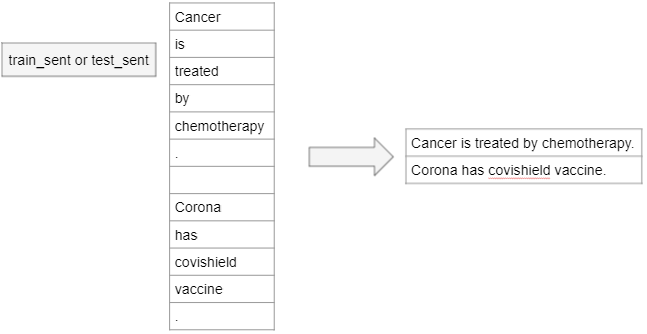

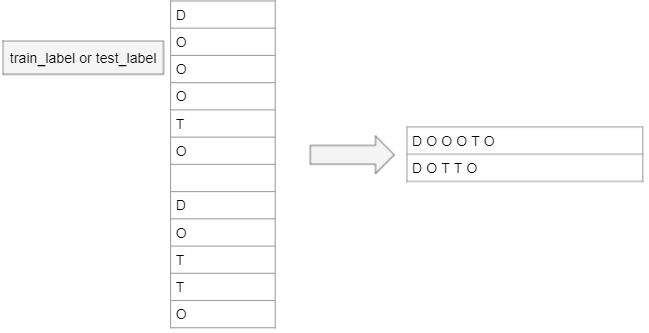

In [38]:
#reading sentences and labels of train data and test data
with open('train_sent', 'r') as train_sent_file:
  train_sentences = train_sent_file.readlines()

with open('train_label', 'r') as train_labels_file:
  train_labels = train_labels_file.readlines()

with open('test_sent', 'r') as test_sent_file:
  test_sentences = test_sent_file.readlines()

with open('test_label', 'r') as test_labels_file:
  test_labels = test_labels_file.readlines()


In [39]:
#splitting line by line to form sentences, returns the list of sentences or list of labels
def sentences_labels(data):
  return (' '.join([line.strip() for line in data])).split('  ')

In [40]:
# Joining the lines to recover the complete sentences.
train_sentences_list = sentences_labels(train_sentences)
print(train_sentences_list)

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )", "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )", 'Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age', 'In the third trimester , the amniotic fluid index ( AFI ) may be affected by maternal fluid status

In [41]:
# Joining the lines to recover the complete sentences.
test_sentences_list = sentences_labels(test_sentences)
print(test_sentences_list)

['Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )', 'As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration', 'The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period', 'There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )', 'Fluctuations in ambient temperature are inversely correlated to changes in AFI', 'This study tested the hypothesis that to reduce the rate of macrosomic infants in gestational diabetes cases , good glycemic control should be initiated before 34 completed gestational weeks', "In the `` early '' and `` late '' groups , mean gestational age at the beginning of tre

In [42]:
# Joining the lines to recover the complete labels.
train_label_list = sentences_labels(train_labels)
print(train_label_list)

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O', 'O O O O O O O D D O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O T T', 'O O O O O O O O', 'O O O O O O O O O O O O O O O O O', 'O O O O O O O O D D D D D D O T T T O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'D D O O O O O D D O 

In [43]:
# Joining the lines to recover the complete labels.
test_label_list = sentences_labels(test_labels)
print(test_label_list)

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O D D', 'O O O O O O O O O O O O O O O O O O O D D O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O', 'D D O O O O O O O O D O D D O O D D D', 'O O O O O O O O O O O O D O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O D O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O 

In [44]:
# print top 5 sentences of train data and test data
def top_sentences(data):
  for line in range(5):
    print('Sentence' + str(line+1) + ': ' + data[line])

In [45]:
# Top 5 sentences of train data
top_sentences(train_sentences_list)

Sentence1: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Sentence2: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Sentence3: Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Sentence4: The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Sentence5: Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )


In [46]:
# Top 5 sentences of train data and test data along with labels
def top_sentences_labels(sentences, labels):
  for line in range(5):
    train = sentences[line].split()
    train_label = labels[line].split()
    sentence_dict = dict(zip(train, train_label))
    print('Sentence' + str(line+1) + ': ' , sentence_dict)

In [47]:
# Top 5 sentences of train data along with labels
top_sentences_labels(train_sentences_list, train_label_list)

Sentence1:  {'All': 'O', 'live': 'O', 'births': 'O', '>': 'O', 'or': 'O', '=': 'O', '23': 'O', 'weeks': 'O', 'at': 'O', 'the': 'O', 'University': 'O', 'of': 'O', 'Vermont': 'O', 'in': 'O', '1995': 'O', '(': 'O', 'n': 'O', '2395': 'O', ')': 'O', 'were': 'O', 'retrospectively': 'O', 'analyzed': 'O', 'for': 'O', 'delivery': 'O', 'route': 'O', ',': 'O', 'indication': 'O', 'cesarean': 'O', 'gestational': 'O', 'age': 'O', 'parity': 'O', 'and': 'O', 'practice': 'O', 'group': 'O', 'to': 'O', 'reflect': 'O', 'risk': 'O', 'status': 'O'}
Sentence2:  {'The': 'O', 'total': 'O', 'cesarean': 'O', 'rate': 'O', 'was': 'O', '14.4': 'O', '%': 'O', '(': 'O', '344': 'O', 'of': 'O', '2395': 'O', ')': 'O', ',': 'O', 'and': 'O', 'the': 'O', 'primary': 'O', '11.4': 'O', '244': 'O', '2144': 'O'}
Sentence3:  {'Abnormal': 'O', 'presentation': 'O', 'was': 'O', 'the': 'O', 'most': 'O', 'common': 'O', 'indication': 'O', '(': 'O', '25.6': 'O', '%': 'O', ',': 'O', '88': 'O', 'of': 'O', '344': 'O', ')': 'O'}
Sentence4:

In [48]:
# Top 5 sentences of test data
top_sentences(test_sentences_list)

Sentence1: Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
Sentence2: As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration
Sentence3: The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period
Sentence4: There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )
Sentence5: Fluctuations in ambient temperature are inversely correlated to changes in AFI


In [49]:
# Top 5 sentences of test data along with labels
top_sentences_labels(test_sentences_list, test_label_list)

Sentence1:  {'Furthermore': 'O', ',': 'O', 'when': 'O', 'all': 'O', 'deliveries': 'O', 'were': 'O', 'analyzed': 'O', 'regardless': 'O', 'of': 'O', 'risk': 'O', 'status': 'O', 'but': 'O', 'limited': 'O', 'to': 'O', 'gestational': 'O', 'age': 'O', '>': 'O', 'or': 'O', '=': 'O', '36': 'O', 'weeks': 'O', 'the': 'O', 'rates': 'O', 'did': 'O', 'not': 'O', 'change': 'O', '(': 'O', '12.6': 'O', '%': 'O', '280': 'O', '2214': 'O', ';': 'O', 'primary': 'O', '9.2': 'O', '183': 'O', '1994': 'O', ')': 'O'}
Sentence2:  {'As': 'O', 'the': 'O', 'ambient': 'O', 'temperature': 'O', 'increases': 'O', ',': 'O', 'there': 'O', 'is': 'O', 'an': 'O', 'increase': 'O', 'in': 'O', 'insensible': 'O', 'fluid': 'O', 'loss': 'O', 'and': 'O', 'potential': 'O', 'for': 'O', 'dehydration': 'O'}
Sentence3:  {'The': 'O', 'daily': 'O', 'high': 'O', 'temperature': 'O', 'ranged': 'O', 'from': 'O', '71': 'O', 'to': 'O', '104': 'O', 'degrees': 'O', 'F': 'O', 'and': 'O', 'AFI': 'O', 'values': 'O', '1.7': 'O', '24.7': 'O', 'cm': 

### Count the number of sentences in the processed train and test dataset 

In [50]:
print(len(train_sentences_list))

2599


In [51]:
print(len(test_sentences_list))

1056


### Count the number of lines of labels in the processed train and test dataset.

In [52]:
print(len(train_label_list))

2599


In [53]:
print(len(test_label_list))

1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [54]:
#combining both train and test sentences to find the freqeuncy of words
all_sentences = test_sentences_list + train_sentences_list
noun_or_propn=[] # initialize empty list
for each_sentence in all_sentences: #looping through all sentences i.e. train and test sentences
    processed_doc=model(each_sentence) # applying the NLP model on the sentence
    for token in processed_doc: # Looping through the tokens created by the model
        if token.pos_=='NOUN' or token.pos_=='PROPN': # Checking if the pos_ tag is 'NOUN' or 'PROPN' 
            noun_or_propn.append(token.lemma_.lower())

In [55]:
import pandas as pd 
# finding freqency of words which are having pos_ tag NOUN oor PROPN
print(pd.Series(noun_or_propn).value_counts().to_dict())

{'patient': 561, 'treatment': 316, '%': 247, 'study': 235, 'cancer': 226, 'cell': 202, 'therapy': 182, 'effect': 181, 'disease': 169, 'group': 145, 'case': 132, 'lung': 120, 'gene': 111, 'rate': 103, 'result': 93, 'use': 92, 'chemotherapy': 91, 'trial': 90, 'woman': 89, 'conclusion': 88, 'analysis': 86, 'protein': 82, 'response': 81, 'year': 79, 'risk': 78, 'child': 77, 'mutation': 75, 'drug': 74, 'tumor': 74, 'method': 73, 'surgery': 73, 'p': 72, 'control': 70, 'infection': 68, 'survival': 67, 'factor': 66, 'dose': 64, 'evidence': 62, 'combination': 62, 'term': 61, 'health': 61, 'age': 61, 'syndrome': 60, 'activity': 60, 'stage': 56, 'mg': 56, 'management': 56, 'care': 56, 'c': 56, 'acid': 54, 'datum': 54, 'bone': 53, 'day': 53, 'time': 53, 'to_see': 52, 'diagnosis': 52, 'carcinoma': 51, 'role': 50, 'b': 50, 'practice': 49, 'week': 47, 'outcome': 47, 'blood': 46, 'pregnancy': 46, 'heart': 45, 'month': 45, 'family': 44, 'system': 44, 'interferon': 43, 'medicine': 43, 'level': 43, 'type

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [56]:
pd.Series(noun_or_propn).value_counts().head(25)

patient         561
treatment       316
%               247
study           235
cancer          226
cell            202
therapy         182
effect          181
disease         169
group           145
case            132
lung            120
gene            111
rate            103
result           93
use              92
chemotherapy     91
trial            90
woman            89
conclusion       88
analysis         86
protein          82
response         81
year             79
risk             78
dtype: int64

## Defining features for CRF





In [57]:
# Let's define the features to get the feature value for one word.
#Define a function to get the above defined features for a word.

def getFeaturesForOneWord(sentence, pos):
  word = sentence[pos]

  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'words.startsWithCapital=%s' % word[0].isupper() # is the word starting with a capital letter
  ]

  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_words.startsWithCapital=%s' % prev_word[0].isupper()
  ])
  else:
    features.append('BEG') # feature to track begin of sentence 

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features

## Getting the features

### Write a code/function to get the features for a sentence

In [58]:
# Define a function to get features for a sentence 
# using the 'getFeaturesForOneWord' function.
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

In [59]:
# Write a code to get features for a sentence.
example_sentence = train_sentences_list[46]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

As there have been few reports of the obstetrical care of affected patients , we wish to document two pregnancies in a woman with a Chronic Progressive External Ophthalmoplegia ( Kearns-Sayre-like syndrome )


['word.lower=have',
 'word[-3:]=ave',
 'word[-2:]=ve',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'prev_word.lower=there',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=False']

### Write a code/function to get the labels of a sentence

In [60]:
# Define a function to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

In [61]:
# Write a code to get the labels for a sentence.
label = train_label_list[5]
print(label)

features = getLabelsInListForOneSentence(label)
features[2]

O O O O O O O O O O O O O O O O O O O O O O O O


'O'

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [62]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences_list]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences_list]

### Define the labels as the target variable for test and the train dataset

In [63]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_label_list]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_label_list]

## Build the CRF Model

In [64]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm=None, all_possible_states=None, all_possible_transitions=None,
    averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [65]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [66]:
# Calculate the f1 score using the test data
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9041392758864858

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

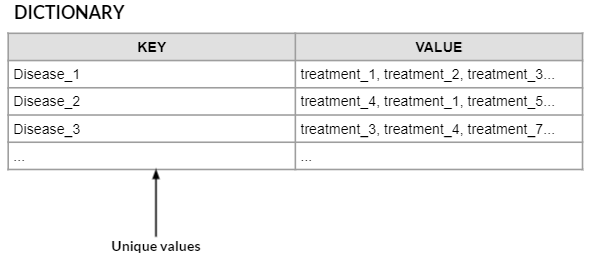

In [67]:
# predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.
for line in range(len(test_sentences_list)):
  test_final = test_sentences_list[line].split()
  test_final_lab = Y_pred[line]
  disease = []
  treatment = []
  for test_f in range(len(test_final_lab)):
    if test_final_lab[test_f] == 'D':
      disease.append(test_final[test_f])
    elif test_final_lab[test_f] == 'T':
      treatment.append(test_final[test_f])
  disease_treatment_dict = dict(zip(disease, treatment))
  if bool(disease_treatment_dict) and bool(treatment):
    disease_treatment_dict = dict(zip([' '.join(disease)], [' '.join(treatment)]))
    print(disease_treatment_dict)

{'hereditary retinoblastoma': 'radiotherapy'}
{'unstable angina or non-Q-wave myocardial infarction': 'roxithromycin'}
{'coronary-artery disease': 'Antichlamydial antibiotics'}
{'primary pulmonary hypertension ( PPH )': 'fenfluramines'}
{'cellulitis': 'G-CSF therapy intravenous antibiotic treatment'}
{'foot infection': 'G-CSF treatment'}
{"early Parkinson 's disease": 'Ropinirole monotherapy'}
{'sore throat': 'Antibiotics'}
{'female stress urinary incontinence': 'surgical treatment'}
{'stress urinary incontinence': 'therapy'}
{'preeclampsia ( proteinuric hypertension )': 'intrauterine insemination with donor sperm versus intrauterine insemination'}
{'cancer': 'organ transplantation and chemotherapy'}
{'major pulmonary embolism': 'Thrombolytic treatment right-side hemodynamics'}
{'malignant pleural mesothelioma': 'thoracotomy , radiotherapy , and chemotherapy'}
{'pulmonary symptoms attributable': 'chemotherapy'}
{'non-obstructive azoospermia': 'testicular fine needle aspiration ( TEFNA 

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

As per above dicrionary {'hereditary retinoblastoma': 'radiotherapy'}

In [68]:
id = 46
print("Sentence:",test_sentences_list[id])
print("Orig Labels:", Y_test[id])
print("Pred Labels:", Y_pred[id])

Sentence: < TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'O', 'O', 'O', 'O', 'O', 'T']


###Conclusion:
 As per above predection the treatment for the disease name: 'hereditary retinoblastoma' is radiotherapy
 